<a href="https://colab.research.google.com/github/s-m-quadri/deep-dos-detect/blob/main/deep_dos_detect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
# Install required libraries quietly (no installation output will be shown)
!pip install pandas numpy scikit-learn matplotlib seaborn xgboost joblib imbalanced-learn --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, f1_score

In [20]:
# Load the "UNSW-NB15 dataset"
#      TYPE: Realistic mix of normal and malicious traffic
#    FORMAT: CSV with 49 features
#    SOURCE: University of New South Wales
#      LINK: https://research.unsw.edu.au/projects/unsw-nb15-dataset

# The dataset is split into training and testing sets.
# We combine them for preprocessing, because both have the same columns.

train_path = "UNSW_NB15_training-set.csv"
test_path = "UNSW_NB15_testing-set.csv"

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

# Combine into one dataframe
df = pd.concat([df_train, df_test], ignore_index=True)

# Create binary label:
# If attack category == 'DoS', label = 1
# Else, label = 0
df['binary_label'] = (df['attack_cat'] == 'DoS').astype(int)

# Drop columns that are irrelevant for prediction:
# id: just a record index
# attack_cat: already encoded into binary_label
# label: original multi-class label
df = df.drop(columns=['id', 'attack_cat', 'label'])

# Separate columns into:
# categorical: text/string-based features
# numeric: numerical features
categorical_cols = df.select_dtypes(include=['object']).columns
numeric_cols = df.select_dtypes(exclude=['object']).columns.drop('binary_label')

# Encode categorical features into numeric format:
# LabelEncoder converts each category to an integer.
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

# Scale numeric features to zero mean and unit variance:
# This helps models like Logistic Regression or Neural Networks converge faster.
scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# Split dataset into:
# Training set: 70%
# Validation set: 30%
# Stratified split to keep class ratio similar in both sets.
X = df.drop(columns=['binary_label'])
y = df['binary_label']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Handle class imbalance using SMOTE:
# SMOTE (Synthetic Minority Oversampling Technique) generates synthetic samples
# for the minority class to balance dataset.
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", np.bincount(y_train))
print("After SMOTE:", np.bincount(y_train_bal))

Before SMOTE: [168924  11447]
After SMOTE: [168924 168924]


In [21]:
# Train XGBoost model:
# n_estimators: number of trees
# max_depth: maximum depth of each tree
# learning_rate: step size shrinkage for better generalization
# subsample: fraction of samples per tree
# colsample_bytree: fraction of features per tree
# min_child_weight, gamma: prevent overfitting by requiring stronger splits
# scale_pos_weight: weight for balancing positive class
# eval_metric: using average precision score (AUC-PR)
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos

model = XGBClassifier(
    n_estimators=400,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    min_child_weight=5,
    gamma=1,
    scale_pos_weight=scale_pos_weight,
    eval_metric='aucpr',
    random_state=42
)
model.fit(X_train_bal, y_train_bal)

# Find best threshold for classification:
# Default is 0.5, but in imbalanced datasets, moving threshold can improve F1 score.
# F1 = harmonic mean of precision & recall.
y_proba = model.predict_proba(X_val)[:, 1]
thresholds = np.linspace(0.1, 0.9, 81)

best_thresh, best_f1 = 0.5, 0
for t in thresholds:
    y_pred_thresh = (y_proba >= t).astype(int)
    f1 = f1_score(y_val, y_pred_thresh)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = t

print(f"Best threshold for DoS detection: {best_thresh:.2f} (F1-score = {best_f1:.4f})")

# Save trained model and threshold for later use.
joblib.dump((model, best_thresh), "dos_detector_model.pkl")
print("Model + best threshold saved as dos_detector_model.pkl")

Best threshold for DoS detection: 0.90 (F1-score = 0.4778)
Model + best threshold saved as dos_detector_model.pkl



Classification Report:
              precision    recall  f1-score   support

     Non-DoS       0.99      0.88      0.93     72396
         DoS       0.33      0.85      0.48      4906

    accuracy                           0.88     77302
   macro avg       0.66      0.87      0.71     77302
weighted avg       0.95      0.88      0.90     77302



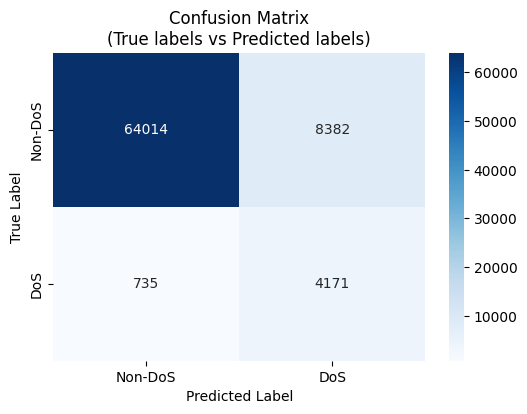

In [22]:
# Load model back (if skipping training)
model, best_thresh = joblib.load("dos_detector_model.pkl")

# Make predictions on validation set using the best threshold.
y_proba = model.predict_proba(X_val)[:, 1]
y_pred = (y_proba >= best_thresh).astype(int)

# Classification Report:
# Shows precision, recall, F1-score for each class.
# Precision: Of predicted DoS, how many are correct
# Recall: Of actual DoS, how many were detected
print("\nClassification Report:")
print(classification_report(y_val, y_pred, target_names=['Non-DoS', 'DoS']))

# Confusion Matrix:
# Rows = actual class, Columns = predicted class
# Helps see exact counts of TP, FP, TN, FN
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-DoS', 'DoS'],
            yticklabels=['Non-DoS', 'DoS'])
plt.title("Confusion Matrix\n(True labels vs Predicted labels)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

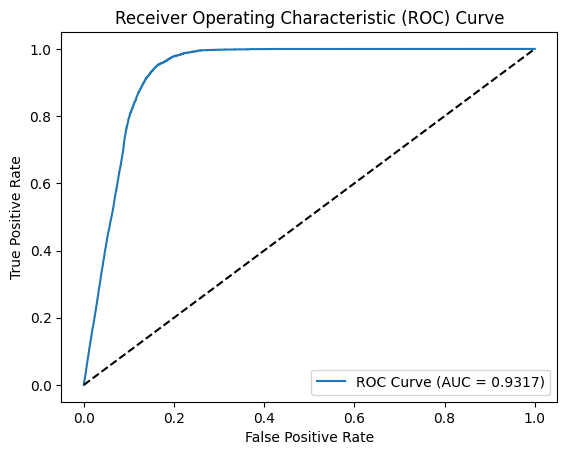

In [23]:
# ROC Curve:
# Plots True Positive Rate vs False Positive Rate
# AUC-ROC: Probability model ranks a random positive higher than a random negative
roc_auc = roc_auc_score(y_val, y_proba)
fpr, tpr, _ = roc_curve(y_val, y_proba)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--')  # Random guess baseline
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.show()

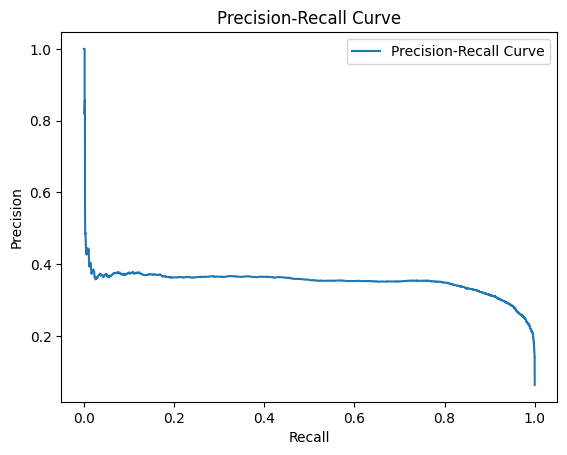

In [24]:
# Precision-Recall Curve:
# Shows trade-off between precision and recall.
# Useful in imbalanced datasets.
precision, recall, _ = precision_recall_curve(y_val, y_proba)
plt.figure()
plt.plot(recall, precision, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

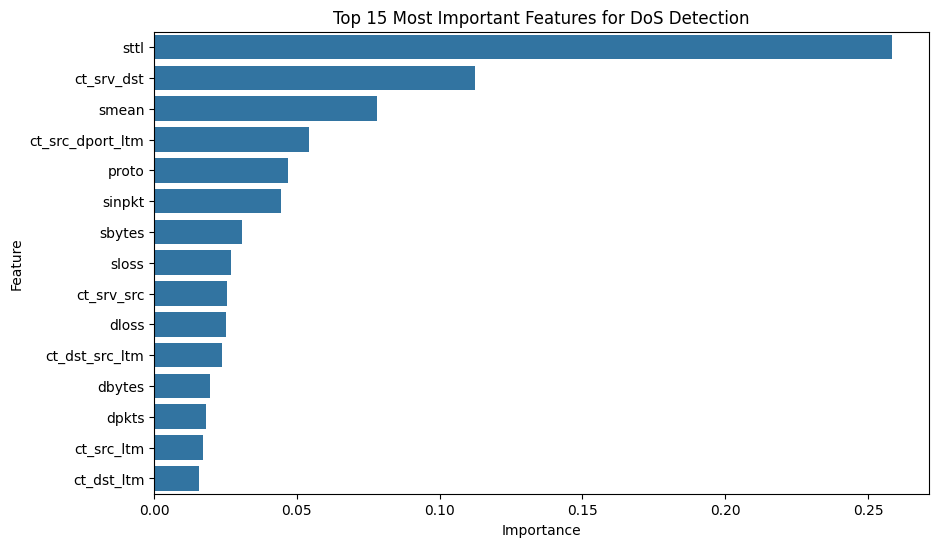

In [25]:
# Feature Importance (Tree-based models):
# Shows which features are most useful for prediction.
if hasattr(model, "feature_importances_"):
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': model.feature_importances_
    }).sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=importance_df.head(15), x='Importance', y='Feature')
    plt.title("Top 15 Most Important Features for DoS Detection")
    plt.show()

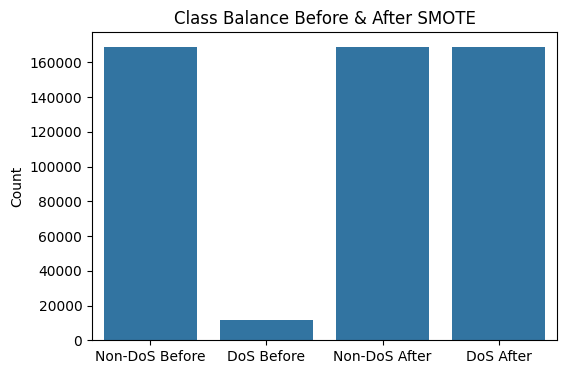

In [26]:
# Class balance before and after SMOTE
counts_before = np.bincount(y_train)
counts_after = np.bincount(y_train_bal)
plt.figure(figsize=(6, 4))
sns.barplot(x=["Non-DoS Before", "DoS Before", "Non-DoS After", "DoS After"],
            y=list(counts_before) + list(counts_after))
plt.title("Class Balance Before & After SMOTE")
plt.ylabel("Count")
plt.show()

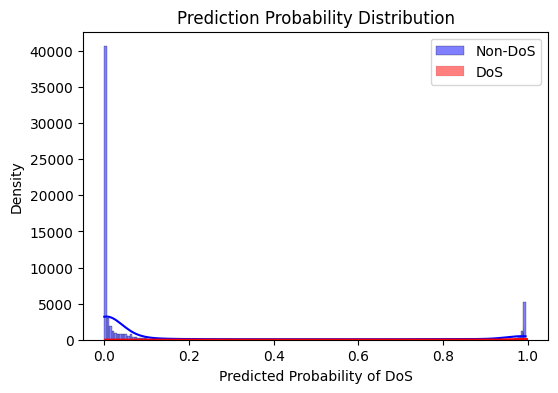

In [27]:
# Distribution of predicted probabilities for each class
# Helps to see model confidence distribution
plt.figure(figsize=(6, 4))
sns.histplot(y_proba[y_val == 0], color="blue", label="Non-DoS", kde=True)
sns.histplot(y_proba[y_val == 1], color="red", label="DoS", kde=True)
plt.xlabel("Predicted Probability of DoS")
plt.ylabel("Density")
plt.title("Prediction Probability Distribution")
plt.legend()
plt.show()

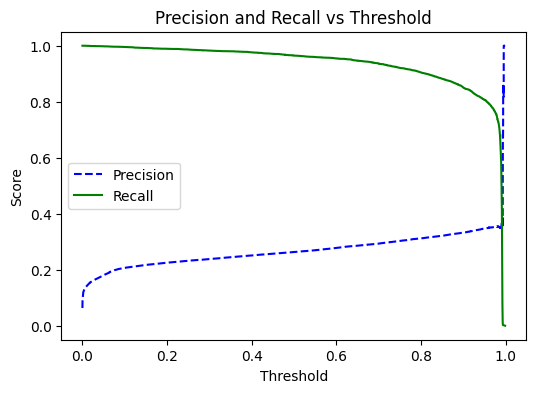

In [28]:
# Precision and Recall vs Decision Threshold
# Helps choose threshold based on desired trade-off
precisions, recalls, thresholds = precision_recall_curve(y_val, y_proba)
plt.figure(figsize=(6, 4))
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision and Recall vs Threshold")
plt.legend()
plt.show()

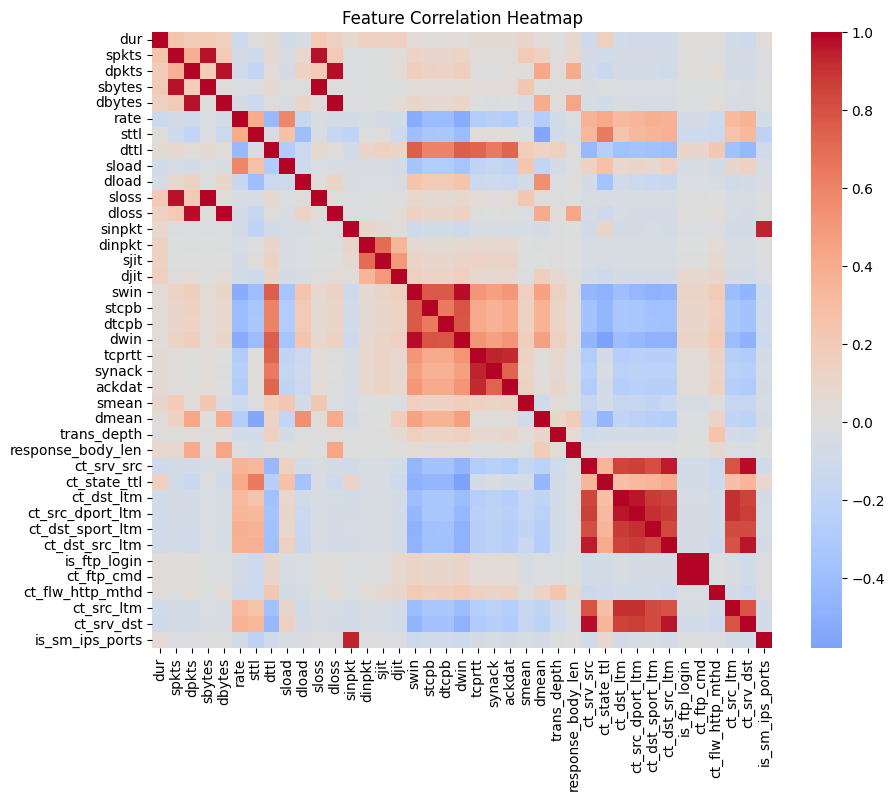

In [29]:
# Correlation heatmap of numeric features
# Helps detect multicollinearity and feature relationships
plt.figure(figsize=(10, 8))
sns.heatmap(df[numeric_cols].corr(), cmap='coolwarm', center=0)
plt.title("Feature Correlation Heatmap")
plt.show()